### Imports

In [94]:
import torch
import torch.distributions as dist
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import seaborn as sns
import random
from tqdm import tqdm

from models import *
from utils import *
from train import *
from bvc import *

sns.set_theme(style='white', font_scale=1.25)
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Environments and Neuron Classes

In [2]:
def compute_bearing(loc, loc2):
    '''
    Helper function: computes the bearing from loc1 (x1, y1) to loc2 (x2, y2)
    
    :param loc: torch.Tensor, n_locs, locs
    '''
    if len(loc.shape) == 2:
        x1, y1 = loc[:,0], loc[:,1] # n_locs, xs
    else:
        x1, y1 = loc[0], loc[1]
    x2, y2 = loc2
    
    bearing = torch.arctan((x2-x1)/(y2-y1))
    
    mask1 = y1 > y2
    bearing += mask1 * torch.pi
    mask2 = bearing < 0
    bearing += mask2 * torch.pi * 2
    
    return bearing

In [336]:
class RectangleEnvironment:
    '''
    Rectangular environment to obtain BVC and PC firing rates
    (0,0) is the bottom left corner, north is 0 bearing
    '''
    def __init__(self, l, w):
        self.l = torch.Tensor([l]) # maximum length
        self.w = torch.Tensor([w]) # maximum width
        self.aspect_ratio = l / w
        self.barriers = [] # list of tuples, each sublist (start_loc, end_loc)
        
    def add_straight_barrier(self, start_loc, end_loc):
        '''
        Adds a straight barrier to the environment.
        The barrier is indistinhuishable to the agent
        '''
        x_start, y_start = start_loc
        x_end, y_end = end_loc
        assert x_start >= 0 and x_end <= self.l
        assert y_start >= 0 and y_end <= self.w
        self.barriers.append(torch.Tensor([[x_start, y_start], [x_end, y_end]]))
        
    def compute_wall_dist(self, loc, n_disc=360):
        '''
        Discretises bearing to 360 and compute the distance to each segment. Takes into account any walls and barriers. Vectorised.
        '''
        x, y = loc
        x = torch.Tensor([x]) if not isinstance(x, torch.Tensor) else x
        y = torch.Tensor([y]) if not isinstance(y, torch.Tensor) else y
        assert torch.any(x) > 0 and torch.any(x) < self.l
        assert torch.any(y) > 0 and torch.any(y) < self.w
        try:
            n_mesh_x, n_mesh_y = x.shape
        except:
            n_mesh_x, n_mesh_y = 1, 1
        
        distances = torch.zeros(n_mesh_x, n_mesh_y, n_disc)
        
        angles = torch.ones(n_disc) * 2 *torch.pi / n_disc
        bearings = torch.linspace(0, 2*torch.pi, n_disc)
        
        # compute bearings to 4 corners
        top_right = torch.arctan((self.l-x)/(self.w-y))
        bottom_right = 1/2 * torch.pi + torch.arctan(y/(self.l-x))
        bottom_left = torch.pi + torch.arctan(x/y)
        top_left = 3/2*torch.pi + torch.arctan((self.w-y)/x)

        for bearing in range(n_disc):
            b = torch.Tensor([2 * torch.pi/n_disc * bearing]) + 1e-3 # bearing in rad

            segment_in_top_mask = torch.logical_or(b >= top_left, b < top_right)
            segment_in_right_mask = torch.logical_and(b >= top_right, b < bottom_right)
            segment_in_bottom_mask = torch.logical_and(b >= bottom_right, b < bottom_left)
            segment_in_left_mask = torch.logical_and(b >= bottom_left, b < top_left)

            assert torch.all(segment_in_top_mask*1 + segment_in_right_mask*1 + segment_in_bottom_mask*1 + segment_in_left_mask*1 == torch.ones(n_mesh_x, n_mesh_y))

            distances[:, :, bearing] += torch.multiply(segment_in_top_mask, (self.w-y)/torch.cos(b))
            distances[:, :, bearing] += torch.multiply(segment_in_right_mask, (self.l-x)/torch.cos(b- 1/2*torch.pi))
            distances[:, :, bearing] += torch.multiply(segment_in_bottom_mask, y/torch.cos(b - torch.pi))
            distances[:, :, bearing] += torch.multiply(segment_in_left_mask, x/torch.cos(b- 3/2 * torch.pi))
            
            if len(self.barriers) > 0:
                m1 = 1/torch.tan(b + 1e-3) # (n_mesh_x, n_mesh_y)
                c1 = y - m1 * x # (n_mesh_x, n_mesh_y)
                
                intersecs = []
                
                for barrier in self.barriers: # has barrier
                    m2 = (barrier[1,1] - barrier[0,1]) / (barrier[1,0] - barrier[0,0]) # m = (y1 - y0) / (x1 - x0)
                    c2 = barrier[1,1] - m2 * barrier[1,0] # c = y1 - m* x1
                    
                    c2 = c2 * torch.ones_like(c1)
                    # system of simultaneuous equations
                    
                    mat_to_inverse = - torch.ones(n_mesh_x, n_mesh_y, 2, 2)
                    mat_to_inverse[:,:,0,0] *= -m1
                    mat_to_inverse[:,:,1,0] *= -m2
                    
                    intersec_loc =  torch.linalg.inv(mat_to_inverse) @  torch.stack((-c1, -c2), dim=-1)[..., None]
                    
                    intersec_x, intersec_y = intersec_loc[:,:,0,0], intersec_loc[:,:,1,0] # (n_mesh_X, n_mesh_y)
                    
                    vec_to_bearing = intersec_loc - torch.stack(loc, dim=-1)[..., None] 
                    barrier_in_direction = torch.sign(vec_to_bearing[:,:,0,0]) == torch.sign(torch.sin(b)) # filter out barriers in negative directions
                    
                    dist_to_barrier = torch.sqrt(torch.pow(vec_to_bearing[:,:,0,0], 2) + torch.pow(vec_to_bearing[:,:,1,0], 2)) # distances to barrier
                    dist_to_barrier = torch.nan_to_num(torch.multiply(1/barrier_in_direction, dist_to_barrier),float('inf'))

                    distances[:,:,bearing] = torch.minimum(distances[:,:,bearing], dist_to_barrier) 
                    
        if n_mesh_x == 1 and n_mesh_y == 1:
            # autoshape
            return distances[0,0,:], bearings, angles
        else:   
            return distances, bearings, angles

    def plot_environment(self):
        '''
        Visualise the environment with all barriers
        '''
        fig, ax = plt.subplots(figsize=(6, 6/self.aspect_ratio))
        background = patches.Rectangle((0, 0), self.w, self.l, facecolor='lightgrey', zorder=-1)
        ax.add_patch(background)
        
        for barrier in self.barriers:
            ax.plot([barrier[0,0], barrier[1,0]], [barrier[0,1], barrier[1,1]], color='grey', linewidth=3) 
        ax.axis('off')
        ax.set_aspect('equal')
        ax.grid(False)
        plt.show()
        
    def generate_mesh(self, n_disc=101):
        '''
        Discritise length and width and generate the distances, bearings, angles from each point.
        '''
        
        x, y = torch.meshgrid(
            torch.linspace(1e-3, self.l.item()-1e-3, n_disc),
            torch.linspace(1e-3, self.w.item()-1e-3, n_disc))
        distances, bearings, angles = self.compute_wall_dist((x,y))
        
        return distances, bearings, angles
    
    def random_sample_locations(self, n_data_points, n_disc=360):
        '''
        Randomly sample n locations in the environment, returns distances, bearings and angles
        
        :returns:
        distances: torch.Tensor shape(n_data_points, n_disc)
        bearing:   torch.Tensor shape(n_data_points, n_disc), discretising (0, 360)
        angles:    torch.Tensor shape(n_data_points, n_disc), one degrees in radian
        '''
        distances, bearings, angles = torch.zeros(n_data_points, n_disc), torch.zeros(n_data_points, n_disc), torch.zeros(n_data_points, n_disc)
        xs = dist.Uniform(low=0, high=self.l).sample(sample_shape=torch.Size([n_data_points]))
        ys = dist.Uniform(low=0, high=self.w).sample(sample_shape=torch.Size([n_data_points]))
        for i, loc in tqdm(enumerate(zip(xs, ys))):
            distance, bearing, angle = self.compute_wall_dist(loc, n_disc=n_disc)
            
            distances[i, :] = distance
            bearings[i, :] = bearing
            angles[i, :] = angle
            
        return distances, bearings, angles
    
    
    def visualise_firing_rates(self, firing_rates, cb=False):
        '''
        Visualises firing map of (predicted) BVCs, PCs or other neurons in the environment
        
        firing_rates: torch.Tensor, shape (mesh_x, mesh_y, #neurons)
        '''
        mesh_x, mesh_y, n_neurons = firing_rates.shape
        
        x, y = torch.meshgrid(
            torch.linspace(1e-3, self.l.item()-1e-3, mesh_x),
            torch.linspace(1e-3, self.w.item()-1e-3, mesh_y))
        
        plt.figure(figsize=(6*n_neurons, 6/self.aspect_ratio))
        for neuron_idx in range(n_neurons):
            plt.subplot(1, n_neurons, neuron_idx+1)
            plt.scatter(x, y, c = firing_rates[:, :, neuron_idx])
            if cb:
                plt.colorbar()
        plt.show()
    
    
    def visualise_cell_firing_field(self, neurons, n_disc=101):
        '''
        Visualises the firing field of a group of neurons
        '''
        
        if not isinstance(neurons, list):
            neurons = [neurons]
        n_neurons = len(neurons)
        
        distances, bearings, angles = self.generate_mesh(n_disc=n_disc)
        
        firing_rates = torch.stack([neuron.compute_firing(distances, bearings, angles) for neuron in neurons], dim=-1)
        self.visualise_firing_rates(firing_rates)

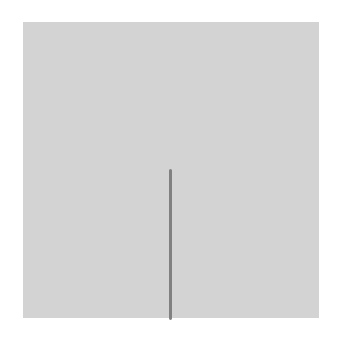

In [337]:
env = RectangleEnvironment(3200, 3200)
env.add_straight_barrier((1600,0),(1600,1600))
env.plot_environment()

In [338]:
class CircleEnvironment:
    '''
    Circular environment to obtain BVC and PC firing rates
    '''
    def __init__(self, radius):
        self.radius = torch.Tensor([radius])
    
    def compute_wall_dist(self, loc, n_disc=360):
        x, y = loc
        x = torch.Tensor([x]) if not isinstance(x, torch.Tensor) else x
        y = torch.Tensor([y]) if not isinstance(y, torch.Tensor) else y
        assert torch.any(torch.pow(x, 2) + torch.pow(y, 2)) < torch.any(torch.pow(self.radius, 2)), 'location not in environment'
        try:
            n_mesh_x, n_mesh_y = x.shape
        except:
            n_mesh_x, n_mesh_y = 1, 1
        
        angle3 = torch.arctan(x/y) # [n_mesh_x, n_mesh_y]
        dist_to_centre = torch.pow(x, 2) + torch.pow(y, 2)
        
        pass
        
    def generate_mesh(self, n_disc=101):
        pass
    
    def random_sample_locations(self, n_data_points, n_disc=360):
        pass
    
    def visualise_firing_rates(self, firing_rates, cb=False):
        pass
        
    def visualise_cell_firing_field(self, neurons, n_disc=101):
        pass

In [339]:
class BoundaryVectorCell:
    '''
    A boundary vector cell initiliased with preferred distance (mm) and angle (rad)
    '''
    def __init__(self, d, phi, sigma_zero=122*3, beta=1830, sigma_ang=0.2, multiplier=1, maxfire=False) -> None:
        self.d = torch.Tensor([d])
        self.phi = torch.Tensor([phi])
        self.sigma_zero = sigma_zero                                                 # Hartley 2000: sigZero = 122 mm
        self.beta = beta                                                             # Hartley 2000: beta = 1830 mm
        self.sigma_ang = torch.Tensor([sigma_ang])                                   # Hartley 2000: angSig = 0.2 rad
        self.sigma_rad = torch.Tensor([((self.d/self.beta)+1) * self.sigma_zero])    # Hartley 2000: sigma_rad = [(d/beta) + 1] * sigma_zero
        self.multiplier = multiplier
        self.maxfire = maxfire

    def compute_BVC_firing_single_segment(self, r, theta):
        '''
        Computes the firing of BVC given a current distance and angle to a single segment.
        Firing rate is proportional to product of two gaussians centerred at the preferred distance and angle
        Vectorised: r and theta can be arrays or matrices
        
        :param r:       animal's allocentric distance to boundary
        :param theta:   animal's allocentric bearing to boundary
        '''
        unscaled_firing_rate = torch.exp(-(r - self.d) ** 2 / (2 * self.sigma_rad ** 2))/ \
                torch.sqrt(2 * torch.pi * self.sigma_rad ** 2) * \
                    torch.exp(-(theta - self.phi) ** 2 / (2 * self.sigma_ang ** 2))/ \
                        torch.sqrt(2 * torch.pi * self.sigma_ang ** 2)
        
        return unscaled_firing_rate
    
    def compute_firing(self, distances, bearings, angles):
        '''
        A section of wall at distance r, bearing theta, subtending a angle dtheta at the rat contributes
        dfi = gi(r, theta) * dtheta
        The firing rate is found by integrating to find the net contribution of all the environment's boundaries
        '''
        n_disc = distances.shape[-1]
            
        unscaled_firing_rates = torch.stack([self.compute_BVC_firing_single_segment(distances[... ,i], bearings[..., i]) for i in range(n_disc)], dim=-1)
        firing_rates = self.multiplier * torch.sum(torch.multiply(unscaled_firing_rates, angles), dim=-1)
        
        if self.maxfire is not False:
            return torch.clamp(firing_rates, min=None, max=self.maxfire)
        else:
            return firing_rates

In [340]:
def plot_bvc_firing_field(bvcs, max_d='auto', axis='on', n=200):
    '''
    Plots firing field of (multiple) BVCs
    '''
    if not isinstance(bvcs, list):
        bvcs = [bvcs]
    n_bvcs = len(bvcs)
    
    if max_d =='auto':
        max_d = int(max([i.d for i in bvcs]) * 1.5)
    rads = torch.linspace(0, 2*torch.pi, n)
    ds = torch.linspace(0, max_d, n)

    rads_mat, ds_mat = torch.meshgrid(rads, ds)

    plt.figure(figsize=(4*n_bvcs, 4))
    for i in range(n_bvcs):
        ax = plt.subplot(1, n_bvcs,i+1, projection='polar')
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location('N', offset=0)
        if axis == 'off':
            ax.set_xticks([])
            ax.set_yticks([])
        firing_rates = bvcs[i].compute_BVC_firing_single_segment(ds_mat, rads_mat)
        ax.scatter(rads_mat, ds_mat, c=firing_rates, s=1, cmap='hsv', alpha=0.75)
    plt.show()

In [341]:
class PlaceCell:
    '''
    A place cell receives input from multiple boundary vector cells
    The firing F_j(x) of PC j at location x is proportional to the thresholded, weighted sum of the N BVC sets that connect to it
    Output is the thresholded firing sum, each at the same allocentric reference frame, scaled by a coefficient A
    '''
    def __init__(self, bvcs=False, connection_weights=False, non_linearity=nn.ReLU(), A=10000, T=False, max_fire=False):
        
        if bvcs is not False:
            self.bvcs = bvcs
            self.n_bvcs = len(self.bvcs)
            self.connection_weights = connection_weights
            assert len(self.connection_weights) == len(self.bvcs)
            
        self.T = T
        self.non_linearity = nn.ReLU()
        self.A = A
        self.max_fire = max_fire
    
    def create_random_bvcs(self, n_bvcs, max_r=1000):
        self.n_bvcs = n_bvcs
        
        rs = dist.Uniform(low=0, high=max_r).sample(sample_shape=torch.Size([n_bvcs]))
        phis = dist.Uniform(0, 2*torch.pi).sample(sample_shape=torch.Size([n_bvcs]))
        
        self.bvcs = [BoundaryVectorCell(rs[i], phis[i]) for i in range(n_bvcs)]
        self.connection_weights = torch.ones(n_bvcs)
        
    def compute_firing(self, distances, bearings, subtended_angles):
        try:
            self.bvcs
        except:
            raise AttributeError('No BVCs initialised')
            
        bvc_firing_rates = torch.stack([bvc.compute_firing(distances, bearings, subtended_angles) for bvc in self.bvcs], dim=-1)
        weighted_sum = torch.sum(torch.mul(bvc_firing_rates, self.connection_weights), dim=-1)
        
        thresholded_sum = self.A * weighted_sum
        
        if self.T == False:
            self.T = 0.9 * torch.max(thresholded_sum)
            
        thresholded_sum = thresholded_sum - self.T
        
        if self.max_fire is False:
            return self.non_linearity(thresholded_sum)
        else:
            return torch.clamp(self.non_linearity(thresholded_sum), min=None, max=self.max_fire)
    
    # to be implemented
    def BCM_weight_update(self, PC_firing, BVC_firings, D=0.2, F0=0.3, p=3, Phi=lambda F, xi: nn.Tanh(F*(F-xi))):
        '''
        Sustained firing of post-synatic cell below a dynamic threshold leads to weakening of the connection from the pre-synaptic cell
        and vice versa.
        Magnitude of change between PC and BVC i is dw = D(f_i(x) Phi(Fj(x), xi)), xi = (<Fj>/F0)^p*<Fj>
        '''
        Fj = torch.mean(PC_firing)
        xi = torch.pow((Fj/F0), p) * Fj
        dW = [D * BVC_firings[i] *Phi(PC_firing, xi) for i in range(self.n_bvcs)]
        
        return dW

In [342]:
class BVC_PC_network:
    def __init__(self, BVCs:list, n_PCs:int, n_BVCs_per_PC:int, connection_indices=False):
        self.BVCs = BVCs
        self.n_BVCs = len(BVCs)
        self.n_PCs = n_PCs
        self.n_BVCs_per_PC = n_BVCs_per_PC
        
        if not connection_indices: # randomly connect BVCs to PCs
            connection_indices = [random.sample(range(100),self.n_BVCs_per_PC) for PC_idx in range(self.n_PCs)]
        
        self.PCs = [PlaceCell(bvcs=[self.BVCs[i] for i in connection_indices[pc_idx]], 
                                    connection_weights=dist.Normal(1,1).sample(sample_shape=torch.Size([n_BVCs_per_PC]))) for pc_idx in range(self.n_PCs)]
    
    def compute_population_firing(self, distances, bearings, subtended_angles):
        
        n_locs = distances.shape[0]
        
        BVCs_population_firing = torch.zeros(n_locs, self.n_BVCs)
        PCs_population_firing = torch.zeros(n_locs, self.n_PCs)
        
        for BVC_idx in range(self.n_BVCs):
            BVCs_population_firing[:, BVC_idx] = self.BVCs[BVC_idx].compute_firing(distances, bearings, subtended_angles)
        
        for PC_idx in range(self.n_PCs):
            PCs_population_firing[:, PC_idx] = self.PCs[PC_idx].compute_firing(distances, bearings, subtended_angles)
        
        return BVCs_population_firing, PCs_population_firing

### Test simulations

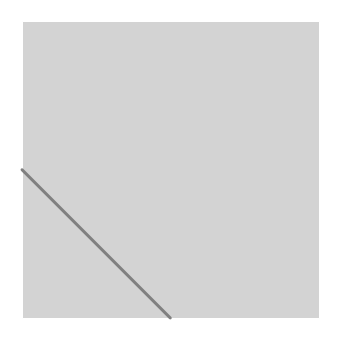

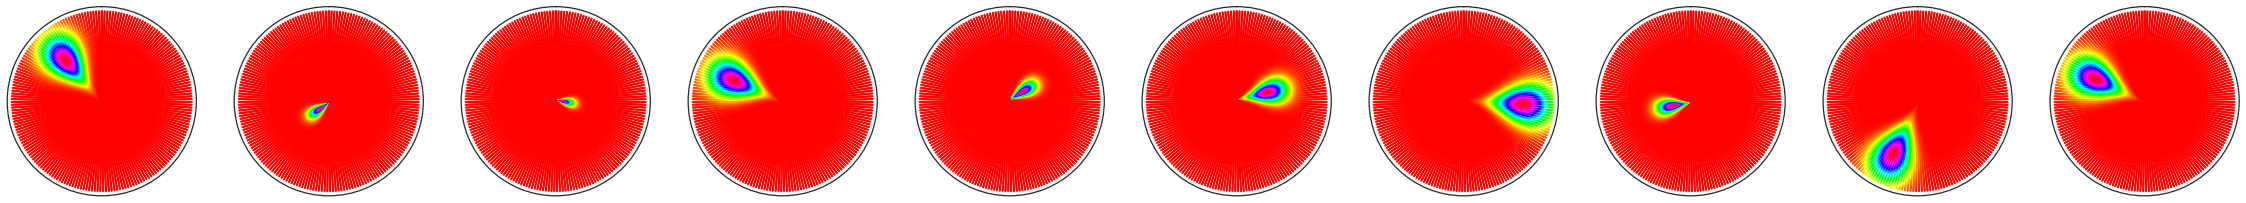

In [345]:
# simute BVCs to feed into a place cell
l = 9600
w = 9600
n_BVCs = 10
env = RectangleEnvironment(l, w)
env.add_straight_barrier((0,4800), (4800,0))
env.plot_environment()
connection_weights = torch.ones(n_BVCs)
dists = dist.Uniform(0,3200).sample(sample_shape=torch.Size([n_BVCs]))
preferred_angle= dist.Uniform(0, 2*torch.pi).sample(sample_shape=torch.Size([n_BVCs]))

BVCs = [BoundaryVectorCell(dists[i], preferred_angle[i]) for i in range(len(dists))]
plot_bvc_firing_field(BVCs[:10], max_d='auto', axis='off')

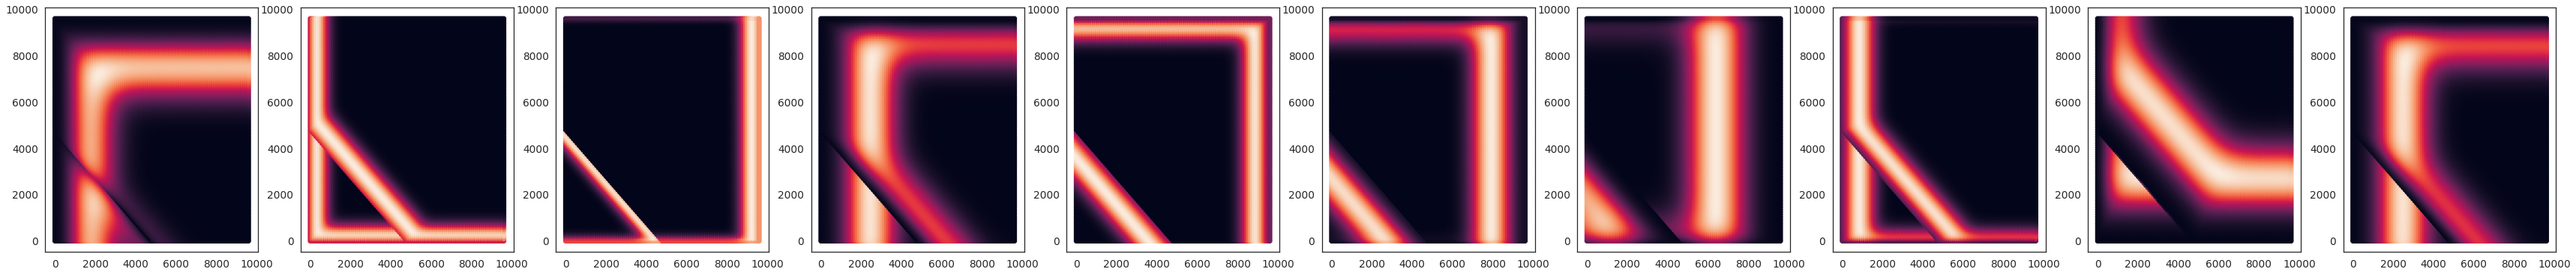

In [346]:
env.visualise_cell_firing_field(BVCs)

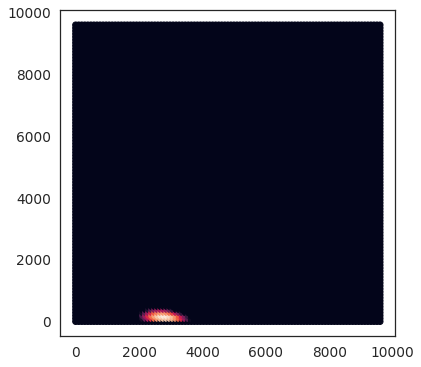

In [347]:
PC1 = PlaceCell(bvcs=BVCs, connection_weights=dist.Normal(2.5,0.5).sample(sample_shape=torch.Size([len(BVCs)])))
env.visualise_cell_firing_field(PC1)

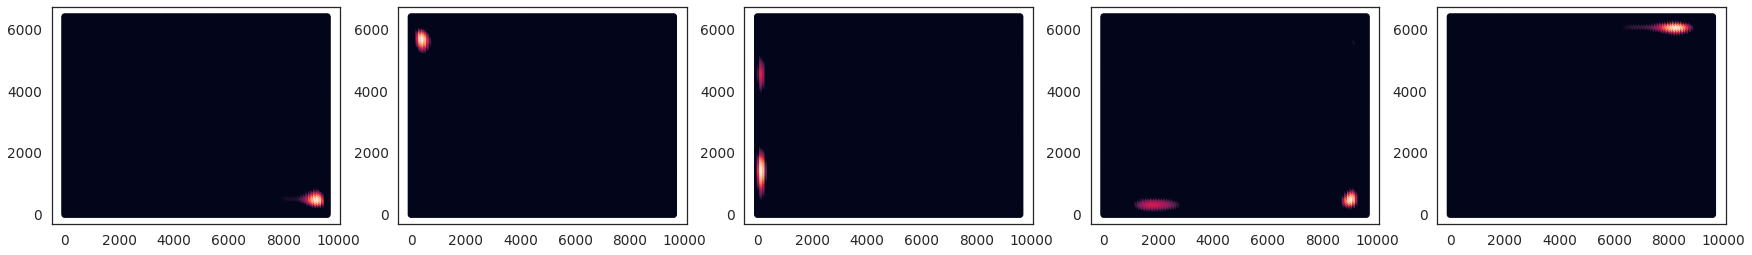

In [83]:
PlaceCells = []
for i in range(5):
    PC = PlaceCell()
    PC.create_random_bvcs(n_bvcs=10, max_r=3200)
    PlaceCells.append(PC)
env.visualise_cell_firing_field(PlaceCells)

### Experiments

In [30]:
l = 25600
w = 25600
n_BVCs = 100
n_PCs = 10
n_BVCs_per_PC = 15

env = RectangleEnvironment(l, w)
connection_weights = torch.ones(n_BVCs)
dists = dist.Uniform(0,6400).sample(sample_shape=torch.Size([n_BVCs]))
preferred_angle= dist.Uniform(0, 2*torch.pi).sample(sample_shape=torch.Size([n_BVCs]))

BVCs = [BoundaryVectorCell(dists[i], preferred_angle[i]) for i in range(len(dists))]

In [31]:
network = BVC_PC_network(BVCs, n_PCs, n_BVCs_per_PC)
env.visualise_cell_firing_field(network.PCs)

NameError: name 'random' is not defined

In [15]:
X_train, Y_train = network.compute_population_firing(*env.random_sample_locations(1000))
X_test, Y_test = network.compute_population_firing(*env.random_sample_locations(100))
X_valid, Y_valid = network.compute_population_firing(*env.random_sample_locations(100))

save_data(X_train, Y_train, './data/', 'BVC_train.pkl')
save_data(X_test, Y_test, './data/', 'BVC_test.pkl')
save_data(X_valid, Y_valid, './data/', 'BVC_valid.pkl')

1000it [00:43, 23.05it/s]
100it [00:04, 24.99it/s]
100it [00:04, 24.18it/s]


In [21]:
X_train, Y_train = load_data('./data/', 'BVC_train.pkl')
X_test, Y_test = load_data('./data/', 'BVC_test.pkl')
X_valid, Y_valid = load_data('./data/', 'BVC_valid.pkl')

In [22]:
batch_size = 20
n_epochs = 1000
train_dataset = BNN_Dataset(X_train, Y_train)
test_dataset = BNN_Dataset(X_test, Y_test)
valid_dataset = BNN_Dataset(X_valid, Y_valid)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

#### Parameter search

In [32]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=1,
    **{'_type':'FF',
       'train_loader':train_dataloader,
       'valid_loader':valid_dataloader,
       'test_loader':test_dataloader,
       'n_epochs':n_epochs,
       'input_dim':100,
       'output_dim':10})

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
1th repeat: best hidden unit: 256, best layers: 3, final eval loss: 0.636210560798645, time elapsed: 0 h 10 m 16 s


In [23]:
# DNN predicts PC firing from recorded BVCs
DNN = FeedForwardDNN(input_dim=100, hidden_dim=256, n_layers=3, output_dim=10).to(device)
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

train_losses, eval_losses = train(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=n_epochs,
    verbose=True, force_stop=False)

Initial eval loss: 2.785337060689926
Epoch 1: training loss 20.731592789292336, eval loss 2.241016924381256. Time elapsed: 0 h 0 m 0 s.
Epoch 51: training loss 11.893517047166824, eval loss 1.042508602142334. Time elapsed: 0 h 0 m 3 s.
Epoch 101: training loss 5.083928084000945, eval loss 0.450698584318161. Time elapsed: 0 h 0 m 6 s.
Epoch 151: training loss 1.2440168047323823, eval loss 0.10283199977129698. Time elapsed: 0 h 0 m 9 s.
Epoch 201: training loss 0.8994157798588276, eval loss 0.07648871745914221. Time elapsed: 0 h 0 m 12 s.
Epoch 251: training loss 0.5877760061994195, eval loss 0.04350931849330664. Time elapsed: 0 h 0 m 15 s.
Epoch 301: training loss 0.34473228082060814, eval loss 0.10359738860279322. Time elapsed: 0 h 0 m 18 s.
Epoch 351: training loss 0.34978474117815495, eval loss 0.045706724748015404. Time elapsed: 0 h 0 m 21 s.
Epoch 401: training loss 0.4558986860793084, eval loss 0.04822701495140791. Time elapsed: 0 h 0 m 24 s.
Epoch 451: training loss 0.69065030990

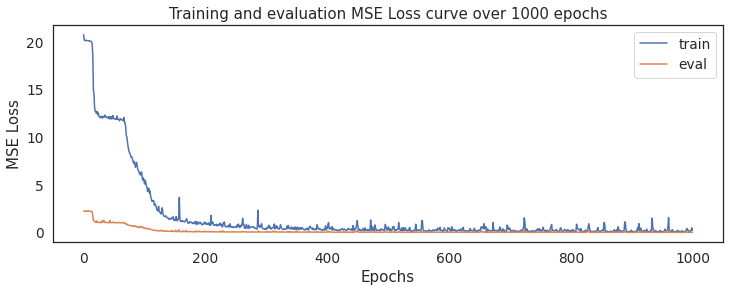

In [24]:
plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

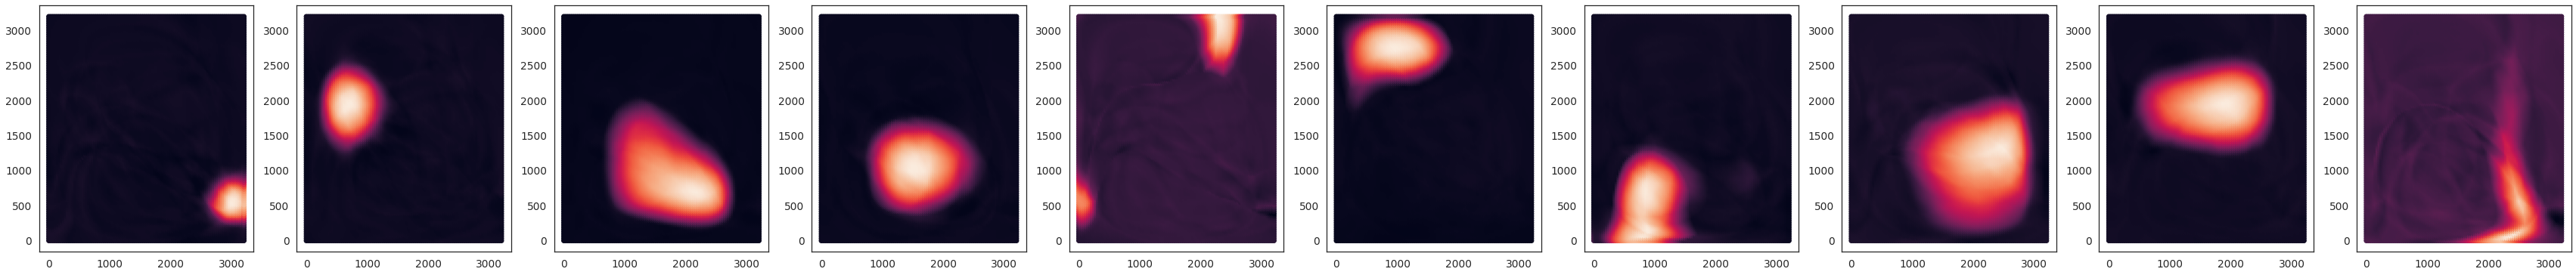

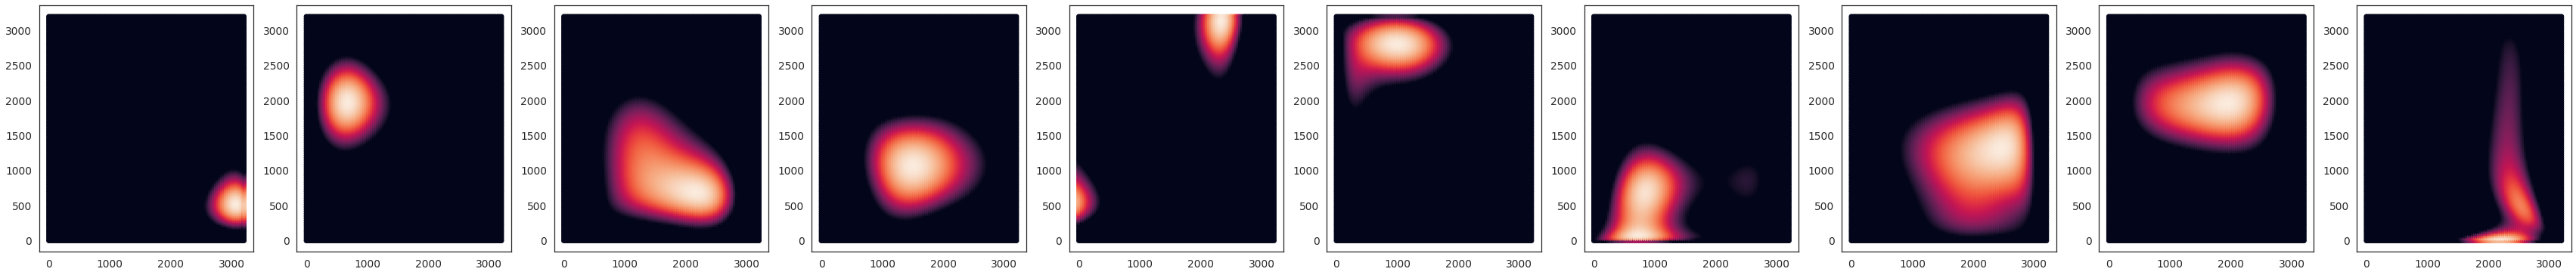

In [37]:
distances, bearings, angles = env.generate_mesh()
BVCs_firing_rates = torch.stack([cell.compute_firing(distances, bearings, angles) for cell in network.BVCs], dim=-1) # BVCs, n_x_mesh, n_y_mesh
with torch.no_grad():
    predicted_PC_firing_rates = DNN(BVCs_firing_rates.to(device))
env.visualise_firing_rates(firing_rates=predicted_PC_firing_rates.detach().cpu().numpy())
env.visualise_cell_firing_field(network.PCs)

Predicted PC firing field


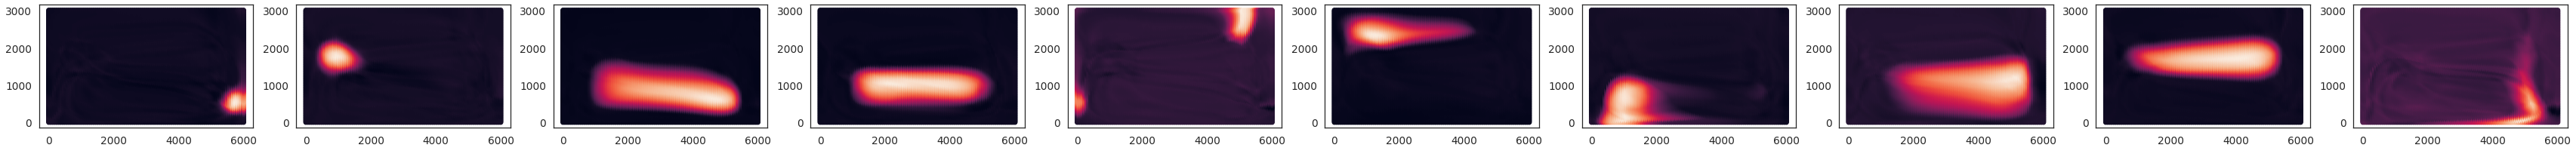

True PC firing field


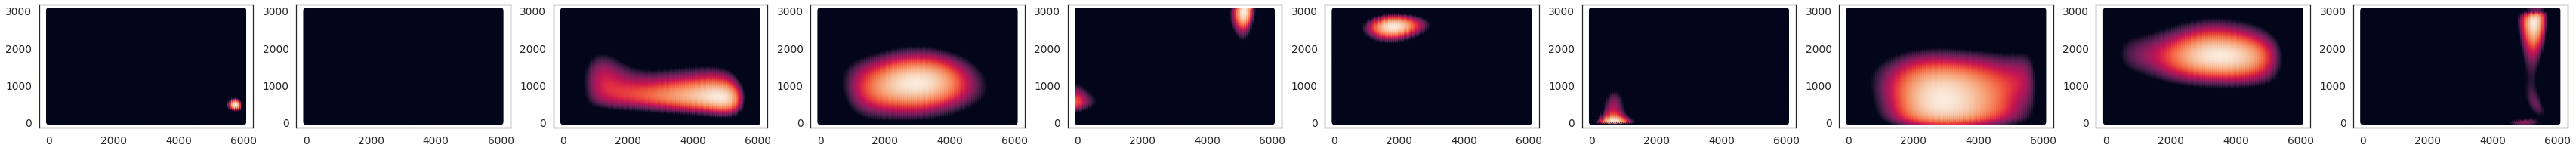

In [44]:
# predict if animal is in a different environment
env2 = RectangleEnvironment(6000, 3000)
distances, bearings, angles = env2.generate_mesh()
BVCs_firing_rates = torch.stack([cell.compute_firing(distances, bearings, angles) for cell in network.BVCs], dim=-1) # BVCs, n_x_mesh, n_y_mesh
with torch.no_grad():
    predicted_PC_firing_rates = DNN(BVCs_firing_rates.to(device))
print('Predicted PC firing field')
env2.visualise_firing_rates(firing_rates=predicted_PC_firing_rates.detach().cpu().numpy())
print('True PC firing field')
env2.visualise_cell_firing_field(network.PCs)

In [1]:
# rat in a box
import ratinabox
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
from ratinabox.Neurons import *

ModuleNotFoundError: No module named 'ratinabox'

In [24]:
Env = Environment(
    params = {'boundary_conditions':'solid',
             'dimensionality':'2D'})
save_plots = False

In [25]:
Env.add_wall(np.array([[0.3, 0.0], [0.3,0.4]]))

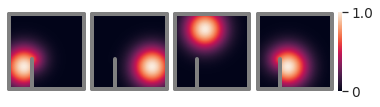

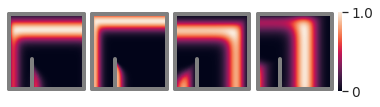

In [28]:
Ag = Agent(Env)
Ag.pos=np.array([0.5,0.5])
Ag.dt = 50e-3
Ag.speed_mean = 0.16
Ag.rotational_velocity_coherence_time = 0.3

#Initialise neuronal populations
PCs = PlaceCells(Ag,
                 params={'n':4,
                         'widths':0.18,
                         'color':'C1',})
PCs.place_cell_centres = np.array([[0.2,0.3],[0.8,0.3],[0.4,0.8],[0.4,0.3]])
# np.random.shuffle(PCs.place_cell_centres)


BVCs = BoundaryVectorCells(Ag,
                params={'n':4,
                        'color':'C3',})




fig, ax = PCs.plot_rate_map(spikes=False)
if save_plots == True: tpl.saveFigure(fig,"pcs")
fig, ax = BVCs.plot_rate_map(spikes=False)
if save_plots == True: tpl.saveFigure(fig,"bvcs")

100%|██████████████████████████████████████| 1200/1200 [00:01<00:00, 812.26it/s]


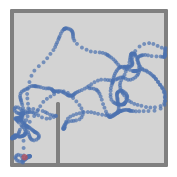

In [29]:
train_time = 60
for i in tqdm(range(int(train_time/Ag.dt))): 
    Ag.update()
    PCs.update()
    GCs.update()
    BVCs.update()

fig, ax = Ag.plot_trajectory(t_end=60)